### lecture 18 - VAR(p),Vector Autoregression

In our previous SARIMAX example, the forecast variable $y_t$ was influenced by the exogenous predictor variable, but not vice versa. That is, the occurrence of a holiday affected restaurant patronage but not the other way around.

However, there are some cases where variables affect each other. <a href='https://otexts.com/fpp2/VAR.html'>Forecasting: Principles and Practice</a> describes a case where changes in personal consumption expenditures $C_t$ were forecast based on changes in personal disposable income $I_t$.
> However, in this case a bi-directional relationship may be more suitable: an increase in $I_t$ will lead to an increase in $C_t$ and vice versa.<br>An example of such a situation occurred in Australia during the Global Financial Crisis of 2008–2009. The Australian government issued stimulus packages that included cash payments in December 2008, just in time for Christmas spending. As a result, retailers reported strong sales and the economy was stimulated. Consequently, incomes increased.

Aside from investigating multivariate time series, vector autoregression is used for
* <a href='https://www.statsmodels.org/devel/vector_ar.html#impulse-response-analysis'>Impulse Response Analysis</a> which involves the response of one variable to a sudden but temporary change in another variable
* <a href='https://www.statsmodels.org/devel/vector_ar.html#forecast-error-variance-decomposition-fevd'>Forecast Error Variance Decomposition (FEVD)</a> where the proportion of the forecast variance of one variable is attributed to the effect of other variables
* <a href='https://www.statsmodels.org/devel/vector_ar.html#dynamic-vector-autoregressions'>Dynamic Vector Autoregressions</a> used for estimating a moving-window regression for the purposes of making forecasts throughout the data sample

#### Formulation
We've seen that an autoregression AR(p) model is described by the following:

&nbsp;&nbsp;&nbsp;&nbsp; $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

A $K$-dimensional VAR model of order $p$, denoted <strong>VAR(p)</strong>, considers each variable $y_K$ in the system.<br>

For example, The system of equations for a 2-dimensional VAR(1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\phi_{ii,l}$ captures the influence of the $l$th lag of variable $y_i$ on itself,<br>
the coefficient $\phi_{ij,l}$ captures the influence of the $l$th lag of variable $y_j$ on $y_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are white noise processes that may be correlated.<br>

Carrying this further, the system of equations for a 2-dimensional VAR(3) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{11,3}y_{1,t-3} + \phi_{12,3}y_{2,t-3} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{21,3}y_{1,t-3} + \phi_{22,3}y_{2,t-3} + \varepsilon_{2,t}$<br><br>

and the system of equations for a 3-dimensional VAR(2) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{13,1}y_{3,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{13,2}y_{3,t-2} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{23,1}y_{3,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{23,2}y_{3,t-2} + \varepsilon_{2,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{3,t} = c_3 + \phi_{31,1}y_{1,t-1} + \phi_{32,1}y_{2,t-1} + \phi_{33,1}y_{3,t-1} + \phi_{31,2}y_{1,t-2} + \phi_{32,2}y_{2,t-2} + \phi_{33,2}y_{3,t-2} + \varepsilon_{3,t}$<br><br>

The general steps involved in building a VAR model are:
* Examine the data
* Visualize the data
* Test for stationarity
* If necessary, transform the data to make it stationary
* Select the appropriate order <em>p</em>
* Instantiate the model and fit it to a training set
* If necessary, invert the earlier transformation
* Evaluate model predictions against a known test set
* Forecast the future

Recall that to fit a SARIMAX model we passed one field of data as our <em>endog</em> variable, and another for <em>exog</em>. With VAR, both fields will be passed in as <em>endog</em>.

#### dataset

For this analysis we'll also compare money to spending. We'll look at the M2 Money Stock which is a measure of U.S. personal assets, and U.S. personal spending. Both datasets are in billions of dollars, monthly, seasonally adjusted. They span the 21 years from January 1995 to December 2015 (252 records).<br>
Sources: https://fred.stlouisfed.org/series/M2SL https://fred.stlouisfed.org/series/PCE

In [98]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [99]:
df = pd.read_csv('./dataset/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

In [100]:
sp = pd.read_csv('./dataset/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [101]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [102]:
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [103]:
df = df.join(sp)

In [104]:
df

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1
...,...,...
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8
2015-10-01,12187.7,12416.1


In [105]:
df.dropna(inplace=True)

In [106]:
df.shape

(252, 2)

<Axes: xlabel='Date'>

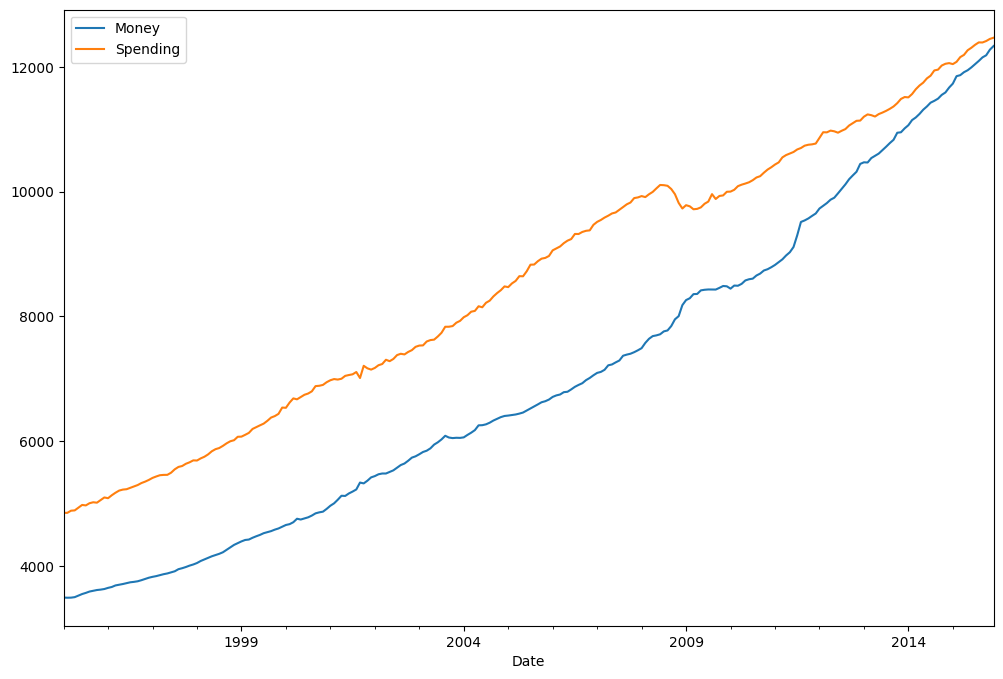

In [107]:
df.plot(figsize=(12,8))

#### test for stationarity, perform any necessary transformations

In [108]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [109]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [110]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Neither variable is stationary, so we'll take a first order difference of the entire DataFrame and re-run the augmented Dickey-Fuller tests. It's advisable to save transformed values in a new DataFrame, as we'll need the original when we later invert the transormations and evaluate the model.

In [111]:
df.diff()

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9
...,...,...
2015-08-01,51.5,38.6
2015-09-01,57.0,-1.2
2015-10-01,33.9,23.3


In [112]:
df_transformed = df.diff()

In [113]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [114]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Since Money is not yet stationary, we'll apply second order differencing to both series so they retain the same number of observations

In [115]:
df_transformed = df_transformed.diff().dropna() # second order differencing

In [116]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [117]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


so now they are both stationary

In [118]:
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


#### train/test split
It will be useful to define a number of observations variable for our test set. For this analysis, let's use 12 months.

In [119]:
nobs = 12 # number of observations

In [120]:
train = df_transformed[:-nobs] # start = beginning of df --> 12 from the end

In [121]:
test = df_transformed[-nobs:] # start at -12 from the end of the df --> go to the end of df

#### gridsearch for order p AR of VAR model
We'll fit a series of models using the first seven p-values, and base our final selection on the model that provides the lowest AIC and BIC scores.

In [122]:
model = VAR(train)

In [123]:
for p in range(8):
    results = model.fit(p)
    print(f'order {p}')
    print(f'AIC: {results.aic}')
    print('\n')

order 0
AIC: 14.74710921809045


order 1
AIC: 14.178610495220896


order 2
AIC: 13.955189367163703


order 3
AIC: 13.849518291541038


order 4
AIC: 13.827950574458281


order 5
AIC: 13.78730034460964


order 6
AIC: 13.799076756885809


order 7
AIC: 13.797638727913972




we choose 5 since gives back the lowest level of AIC. from order 6 the AIC starts to increase

In [124]:
results = model.fit(5)

In [125]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Jan, 2025
Time:                     16:18:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

#### predict the next 12 values
Unlike the VARMAX model we'll use in upcoming sections, the VAR <tt>.forecast()</tt> function requires that we pass in a lag order number of previous observations as well. Unfortunately this forecast tool doesn't provide a DateTime index - we'll have to do that manually.

In [134]:
# grab the last 5 lagged values, right before the test starts
train.values.shape

(238, 2)

In [127]:
lagged_values = train.values[-5:]

In [128]:
z = results.forecast(y=lagged_values,steps=12)

forecasted values for money and spending but are still in terms of second order difference

In [129]:
z 

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [135]:
idx = pd.date_range('2015-01-01',periods=12,freq='MS')

In [136]:
idx

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [138]:
df_forecast = pd.DataFrame(data=z,index=idx,columns=['Money_2d','Spending_2d']) #2d for 'differenced twice'

In [139]:
df_forecast # predicted values

,Money_2d,Spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


In [133]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


#### invert the transformation
Remember that the forecasted values represent second-order differences. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

Here we'll use the <tt>nobs</tt> variable we defined during the train/test/split step.

In [140]:
# add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money_2d'].cumsum()

# now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [142]:
# add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending_2d'].cumsum()

# now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [143]:
df_forecast.head()

,Money_2d,Spending_2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


#### plotting

In [145]:
test_range = df[-nobs:]

<Axes: xlabel='Date'>

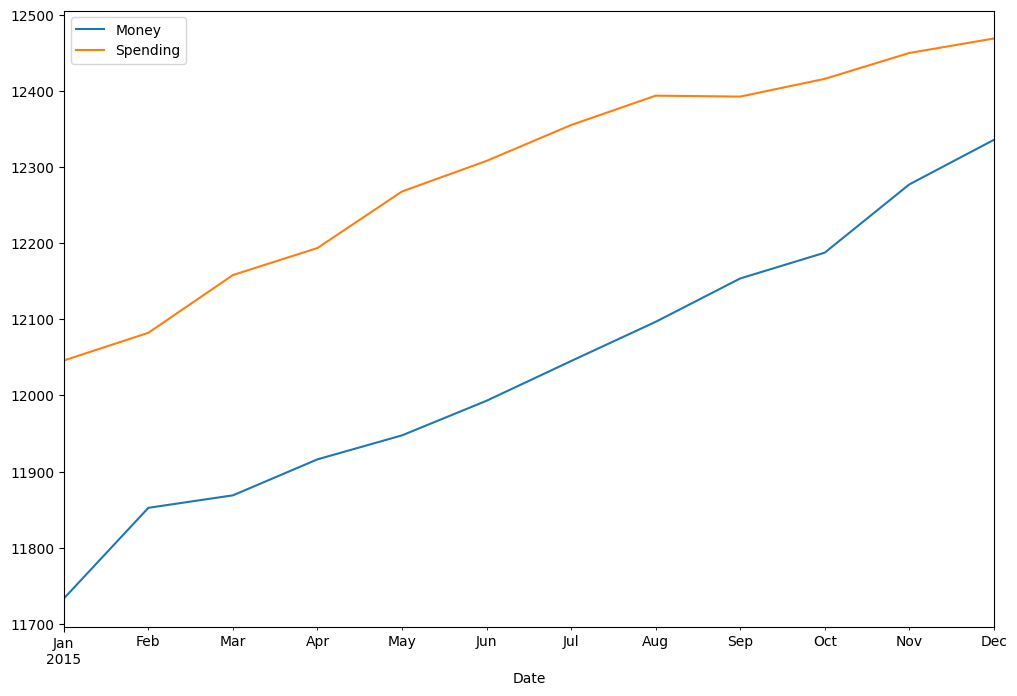

In [146]:
test_range.plot(figsize=(12,8))

In [147]:
df_forecast.columns

Index(['Money_2d', 'Spending_2d', 'Money1d', 'MoneyForecast', 'Spending1d',
       'SpendingForecast'],
      dtype='object')

<Axes: >

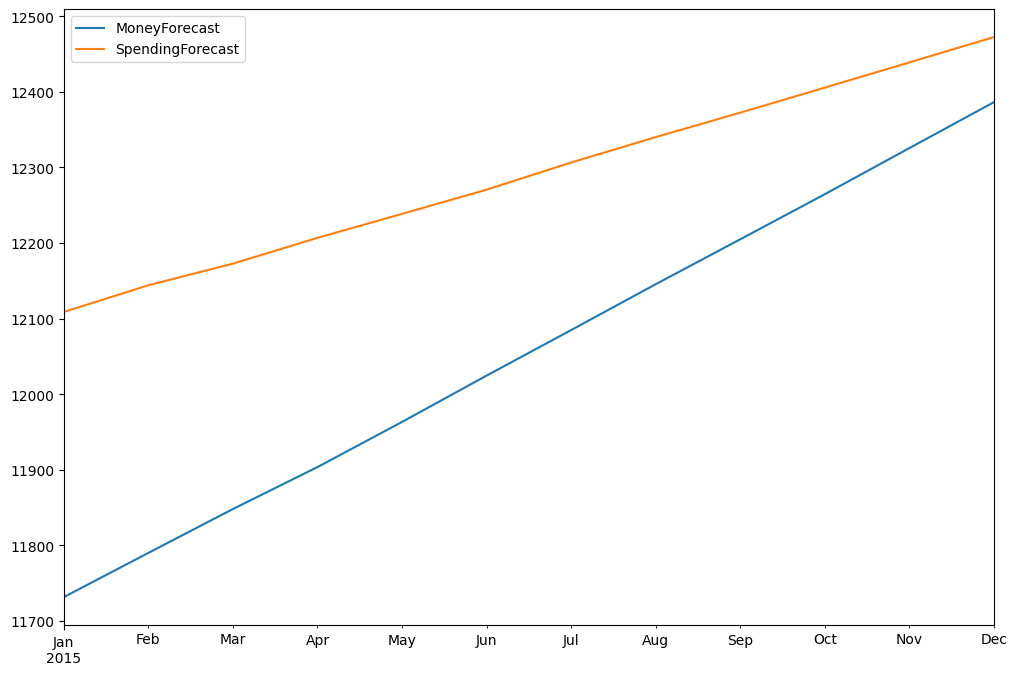

In [149]:
df_forecast[['MoneyForecast','SpendingForecast']].plot(figsize=(12,8))

<Axes: xlabel='Date'>

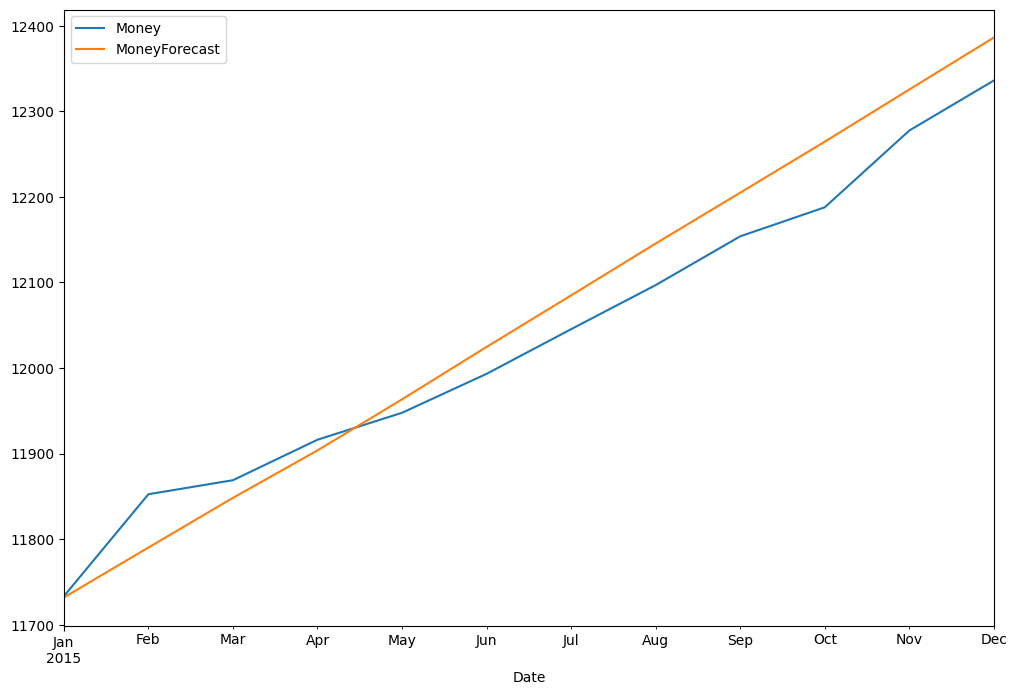

In [150]:
test_range['Money'].plot(figsize=(12,8),legend=True)
df_forecast['MoneyForecast'].plot(legend=True)

<Axes: xlabel='Date'>

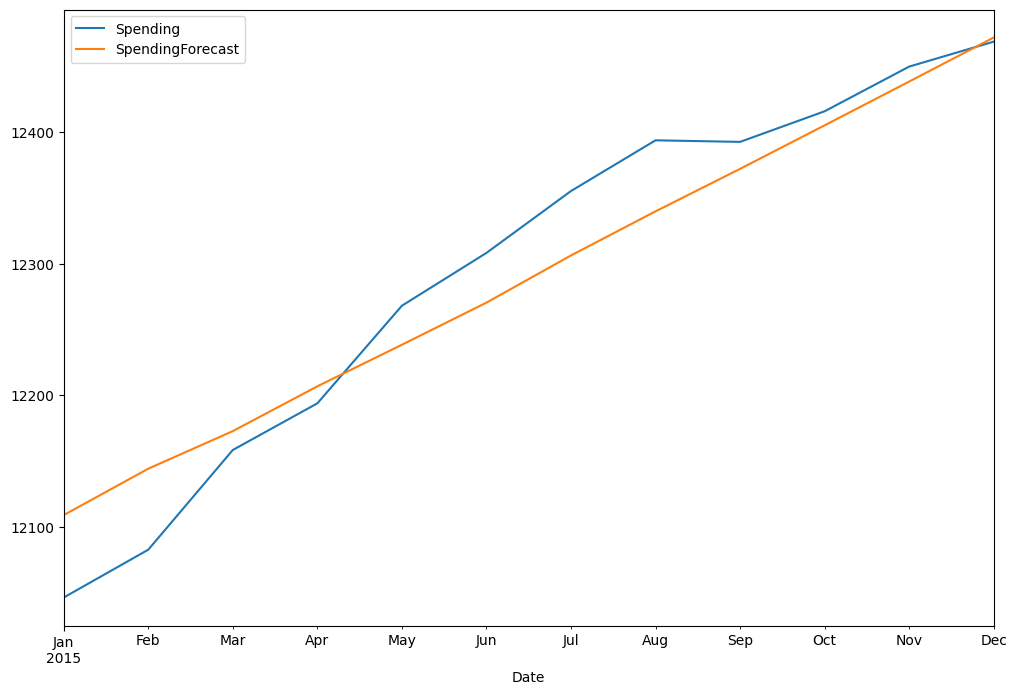

In [151]:
test_range['Spending'].plot(figsize=(12,8),legend=True)
df_forecast['SpendingForecast'].plot(legend=True)

In [152]:
rmse(test_range['Money'],df_forecast['MoneyForecast'])

43.71049653558893

In [153]:
test_range['Money'].mean()

12034.008333333333

In [155]:
rmse(test_range['Spending'],df_forecast['SpendingForecast'])

37.00117516940808

In [156]:
test_range['Spending'].mean()

12294.533333333335